In [1]:
!unzip "/content/drive/MyDrive/datasets/archive.zip"

Streaming output truncated to the last 5000 lines.
  inflating: 2750/River/River_1449.jpg  
  inflating: 2750/River/River_145.jpg  
  inflating: 2750/River/River_1450.jpg  
  inflating: 2750/River/River_1451.jpg  
  inflating: 2750/River/River_1452.jpg  
  inflating: 2750/River/River_1453.jpg  
  inflating: 2750/River/River_1454.jpg  
  inflating: 2750/River/River_1455.jpg  
  inflating: 2750/River/River_1456.jpg  
  inflating: 2750/River/River_1457.jpg  
  inflating: 2750/River/River_1458.jpg  
  inflating: 2750/River/River_1459.jpg  
  inflating: 2750/River/River_146.jpg  
  inflating: 2750/River/River_1460.jpg  
  inflating: 2750/River/River_1461.jpg  
  inflating: 2750/River/River_1462.jpg  
  inflating: 2750/River/River_1463.jpg  
  inflating: 2750/River/River_1464.jpg  
  inflating: 2750/River/River_1465.jpg  
  inflating: 2750/River/River_1466.jpg  
  inflating: 2750/River/River_1467.jpg  
  inflating: 2750/River/River_1468.jpg  
  inflating: 2750/River/River_1469.jpg  
  inflat

In [2]:
# Importing few libraries
import os
import shutil
import random
from tqdm import tqdm

import numpy as np
import pandas as pd

import PIL
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# dir_path = os.path.dirname(os.path.realpath(__file__))
cwd = os.getcwd()
cwd

'/content'

In [4]:
DATASET = "/content/2750"

LABELS = os.listdir(DATASET)
print(LABELS)
print(len(LABELS))

['Industrial', 'Highway', 'SeaLake', 'Pasture', 'River', 'Residential', 'Forest', 'PermanentCrop', 'HerbaceousVegetation', 'AnnualCrop']
10


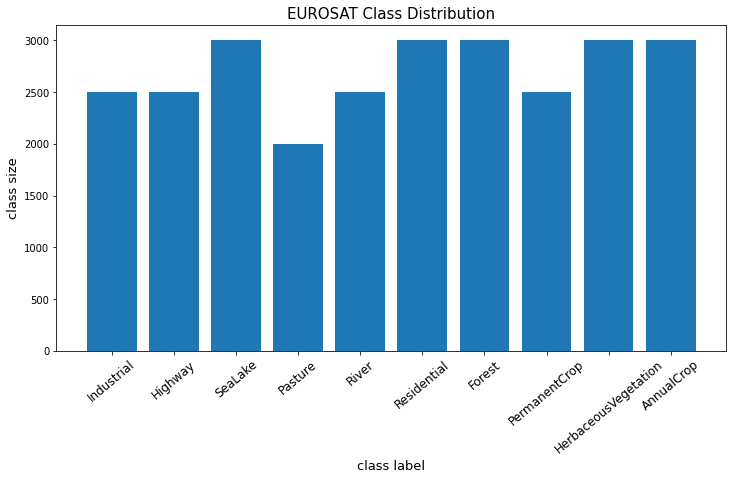

In [5]:
# plot class distributions of whole dataset
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(DATASET, l)))

# print(counts)

plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

The dataset is split into 10 classes of land cover. Each class varies in size, so I'll have to stratify later on when splitting the data into training, testing and validation sets.



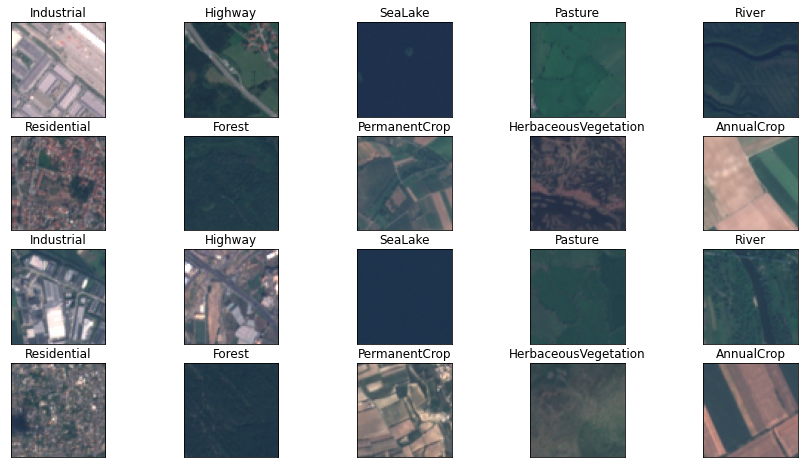

In [6]:
img_paths = [os.path.join(DATASET, l, l+'_1000.jpg') for l in LABELS]
# print(img_paths)
img_paths = img_paths + [os.path.join(DATASET, l, l+'_2000.jpg') for l in LABELS]
# print(img_paths)

def plot_sat_imgs(paths):
    plt.figure(figsize=(15, 8))
    for i in range(20):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = PIL.Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('/')[-2])

plot_sat_imgs(img_paths)

Looking at the preview of the different classes, we can see some similarities and stark differences between the classes.

Urban environments such as Highway, Residential and Industrial images all contain structures and some roadways.

AnnualCrops and PermanentCrops both feature agricultural land cover, with straight lines dilineating different crop fields.

Finally, HerbaceaousVegetation, Pasture, and Forests feature natural land cover; Rivers also could be categorized as natural land cover as well, but may be easier to distinguish from the other natural classes.

If we consider the content of each image, we might be able to estimate which classes might be confused for each other. For example, an image of a river might be mistaken for a highway. Or an image of a highway junction, with surrounding buildings, could be mistaken for an Industrial site. We'll have to train a classifier powerful enough to differentiate these nuances.

Sentinel-2 satellite images could also be downloaded with 10+ additional bands. Near-Infrared Radiation bands, for example, is a band of data that is available for this dataset. NIR can be used to create an index, visualising the radiation that is present (or not present) in a picture. This dataset does not contain the NIR wavelength bands, so this option will not be explored. But it's worth pointing out that this classification task could be addressed in another way using NIR data.



**II. Preprocessing**
---
I'd like to evaluate the performance of the model later on after training, so I'll perform a stratified shuffle-split using Scikit-learn to maintain class proportions. 30% of the dataset will be held for evaluation purposes. I'll be loading my data into the Keras model using the ImageDataGenerator class. I'll need the images to be in their own respective land cover directories.

After splitting the dataset, I'll create some image augmentations using the generator and also denote a subset of the training data to be used as validation data during training.



In [7]:
import re
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator

BASE_DIR = '/content/working'
TRAIN_DIR = '/content/working/training'
TEST_DIR = '/content/working/testing'
BATCH_SIZE = 64
NUM_CLASSES=len(LABELS)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'

# create base directory
if not os.path.exists(BASE_DIR):
  os.mkdir(BASE_DIR)

# create training and testing directories
for path in (TRAIN_DIR, TEST_DIR):
  if not os.path.exists(path):
    os.mkdir(path)

# create class label subdirectories in train and test
for l in LABELS:
    
    if not os.path.exists(os.path.join(TRAIN_DIR, l)):
        os.mkdir(os.path.join(TRAIN_DIR, l))

    if not os.path.exists(os.path.join(TEST_DIR, l)):
        os.mkdir(os.path.join(TEST_DIR, l))

In [8]:
# map each image path to their class label in 'data'
data = {}

for l in LABELS:
    for img in os.listdir(DATASET+'/'+l):
        data.update({os.path.join(DATASET, l, img): l})
X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=69)
# split the list of image paths
for train_idx, test_idx in split.split(X, y):
    
    train_paths = X[train_idx]
    test_paths = X[test_idx]
    # define a new path for each image depending on training or testing
    new_train_paths = [re.sub('/content/2750', '/content/working/training', i) for i in train_paths]
    new_test_paths = [re.sub('/content/2750', '/content/working/testing', i) for i in test_paths]

    train_path_map = list((zip(train_paths, new_train_paths)))
    test_path_map = list((zip(test_paths, new_test_paths)))

    # move the files
    print("moving training files..")
    for i in tqdm(train_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])
    
    print("moving testing files..")
    for i in tqdm(test_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])
    print("hogaya move karke..")

  4%|▍         | 915/21600 [00:00<00:02, 9114.80it/s]

moving training files..


 18%|█▊        | 977/5400 [00:00<00:00, 9766.28it/s]

moving testing files..


100%|██████████| 5400/5400 [00:00<00:00, 7170.28it/s]

hogaya move karke..


In [9]:
# Create a ImageDataGenerator Instance which can be used for data augmentation

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True
#   validation_split=0.2
)

train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    #subset='training',
    color_mode='rgb',
    shuffle=True,
    seed=69
)
# The validation set is optional if we choose to do that
"""
valid_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    subset='validation',    
    color_mode='rgb',
    shuffle=True,
    seed=69
)
"""
# test generator for evaluation purposes with no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [10]:
print(train_generator.class_indices)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [11]:
np.save('class_indices', train_generator.class_indices)

# III. Machine Learning for Image Classification

First, we will see how a machine learning model performs by directly feeding it the whole image pixels (64x64x3 = 12288). From our 80-20 split on the 27000 samples dataset the training data is of size 21600 and test data is of size 5400. Now, here I will use some trick to utilize keras ImageDataGenerator such that we can obtain the image dataset as a numpy array which can be used by a machine learning model for training and testing. 

Now, here I will test Random Forest Classifier. First by using the direct implementation provided by scikit-learn and other implemented from scratch. This notebook is a part of my course project because of which I have included this additional implementation from scratch. Feel free to check it out or you can skip over it if you want.


In [ ]:
# Using image data generator api in keras for making image dataset 
rf_gen = ImageDataGenerator(rescale=1./255)

rf_train_generator = rf_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    # by using batch_size as training data size we can extract data from this iterator
    batch_size=21600, 
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=7
)

rf_test_generator = rf_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=5400,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=7
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [ ]:
train = rf_train_generator.next()
X_train = train[0].reshape(21600, 12288)
y_train = train[1]

test = rf_test_generator.next()
X_test = test[0].reshape(5400, 12288)
y_test = test[1]

### 1. Random Forest Scikit-Learn Implementation

In [ ]:
# Creating mini batches of training data as training on whole data is difficult
ids_1 = np.random.choice(len(X_train), size=21600, replace=False)
X_train_mini_1 = X_train[ids_1]
y_train_mini_1 = rf_train_generator.classes[ids_1]

In [ ]:
# import random forest classifier
from sklearn import ensemble
from sklearn.metrics import accuracy_score


rf_clf = ensemble.RandomForestClassifier(n_estimators=20, n_jobs=-1, random_state=7)
rf_clf.fit(X_train_mini_1, y_train_mini_1)
y_pred = rf_clf.predict(X_test)
acc = accuracy_score(y_pred, rf_test_generator.classes)
print("Accuracy Score: {0:.4}".format(acc))

Accuracy Score: 0.6239


### 2. Random Forest Implementation from scratch
The dataset size is quite large (21600x12288).With scikit-learn's implementation of Random Forest we were barely able to train the model. The implementation from scratch is however not that efficient so we will only provide it with a fraction of training data. Still it can be observed that it produces reasonable accuracy considering for a 10 class classification problem a random guessing approach gives accuracy of 10%

In [ ]:
from __future__ import division
from collections import Counter
import random
import numpy as np
from scipy.stats import mode


def shuffle_in_unison(a, b):
    """ Shuffles two lists of equal length and keeps corresponding elements in the same index. """
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)


def entropy(Y):
    """ In information theory, entropy is a measure of the uncertanty of a random sample from a group. """
    
    distribution = Counter(Y)
    s = 0.0
    total = len(Y)
    for y, num_y in distribution.items():
        probability_y = (num_y/total)
        s += (probability_y)*np.log(probability_y)
    return -s


def information_gain(y, y_true, y_false):
    """ The reduction in entropy from splitting data into two groups. """
    return entropy(y) - (entropy(y_true)*len(y_true) + entropy(y_false)*len(y_false))/len(y)

In [ ]:
# Implementing a Decision Tree Classifier

class DecisionTreeClassifier(object):
    """ A decision tree classifier.
    A decision tree is a structure in which each node represents a binary
    conditional decision on a specific feature, each branch represents the
    outcome of the decision, and each leaf node represents a final
    classification.
    """

    def __init__(self, max_features=lambda x: x, max_depth=10,
                    min_samples_split=2):
        """
        Args:
            max_features: A function that controls the number of features to
                randomly consider at each split. The argument will be the number
                of features in the data.
            max_depth: The maximum number of levels the tree can grow downwards
                before forcefully becoming a leaf.
            min_samples_split: The minimum number of samples needed at a node to
                justify a new node split.
        """

        self.max_features = max_features
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split


    def fit(self, X, y):
        """ Builds the tree by chooseing decision rules for each node based on
        the data. """

        n_features = X.shape[1]
        n_sub_features = int(self.max_features(n_features))
        feature_indices = random.sample(range(n_features), n_sub_features)
        
        self.trunk = self.build_tree(X, y, feature_indices, 0)


    def predict(self, X):
        """ Predict the class of each sample in X. """

        num_samples = X.shape[0]
        y = np.empty(num_samples)
        for j in range(num_samples):
            node = self.trunk

            while isinstance(node, Node):
                if X[j][node.feature_index] <= node.threshold:
                    node = node.branch_true
                else:
                    node = node.branch_false
            y[j] = node

        return y


    def build_tree(self, X, y, feature_indices, depth):
        """ Recursivly builds a decision tree. """

        if depth is self.max_depth or len(y) < self.min_samples_split or entropy(y) is 0:
            return mode(y)[0][0]
        
        feature_index, threshold = find_split(X, y, feature_indices)

        X_true, y_true, X_false, y_false = split(X, y, feature_index, threshold)
        if y_true.shape[0] is 0 or y_false.shape[0] is 0:
            return mode(y)[0][0]
        
        branch_true = self.build_tree(X_true, y_true, feature_indices, depth + 1)
        branch_false = self.build_tree(X_false, y_false, feature_indices, depth + 1)

        return Node(feature_index, threshold, branch_true, branch_false)


def find_split(X, y, feature_indices):
    """ Returns the best split rule for a tree node. """

    num_features = X.shape[1]

    best_gain = 0
    best_feature_index = 0
    best_threshold = 0
    for feature_index in feature_indices:
        values = sorted(set(X[:, feature_index])) ### better way

        for j in range(len(values) - 1):
            threshold = (values[j] + values[j+1])/2
            X_true, y_true, X_false, y_false = split(X, y, feature_index, threshold)
            gain = information_gain(y, y_true, y_false)

            if gain > best_gain:
                best_gain = gain
                best_feature_index = feature_index
                best_threshold = threshold

    return best_feature_index, best_threshold


class Node(object):
    """ A node in a decision tree with the binary condition xi <= t. """

    def __init__(self, feature_index, threshold, branch_true, branch_false):
        self.feature_index = feature_index
        self.threshold = threshold
        self.branch_true = branch_true
        self.branch_false = branch_false


def split(X, y, feature_index, threshold):
    """ Splits X and y based on the binary condition xi <= threshold. """

    X_true = []
    y_true = []
    X_false = []
    y_false = []

    for j in range(len(y)):
        if X[j][feature_index] <= threshold:
            X_true.append(X[j])
            y_true.append(y[j])
        else:
            X_false.append(X[j])
            y_false.append(y[j])

    X_true = np.array(X_true)
    y_true = np.array(y_true)
    X_false = np.array(X_false)
    y_false = np.array(y_false)

    return X_true, y_true, X_false, y_false

In [ ]:
# Implementing Random Forest Clasifier

class RandomForestClassifier(object):
    """ A random forest classifier.
    A random forest is a collection of decision trees that vote on a
    classification decision. Each tree is trained with a subset of the data and
    features.
    """

    def __init__(self, n_estimators=32, max_features=np.sqrt, max_depth=10,
        min_samples_split=2, bootstrap=0.9):
        """
        Args:
            n_estimators: The number of decision trees in the forest.
            max_features: Controls the number of features to randomly consider
                at each split.
            max_depth: The maximum number of levels that the tree can grow
                downwards before forcefully becoming a leaf.
            min_samples_split: The minimum number of samples needed at a node to
                justify a new node split.
            bootstrap: The fraction of randomly choosen data to fit each tree on.
        """
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.bootstrap = bootstrap
        self.forest = []


    def fit(self, X, y):
        """ Creates a forest of decision trees using a random subset of data and
            features. """
        self.forest = []
        n_samples = len(y)
        n_sub_samples = round(n_samples*self.bootstrap)
        
        for i in range(self.n_estimators):
            shuffle_in_unison(X, y)
            X_subset = X[:n_sub_samples]
            y_subset = y[:n_sub_samples]

            tree = DecisionTreeClassifier(self.max_features, self.max_depth,
                                            self.min_samples_split)
            tree.fit(X_subset, y_subset)
            self.forest.append(tree)


    def predict(self, X):
        """ Predict the class of each sample in X. """
        n_samples = X.shape[0]
        n_trees = len(self.forest)
        predictions = np.empty([n_trees, n_samples])
        for i in range(n_trees):
            predictions[i] = self.forest[i].predict(X)

        return mode(predictions)[0][0]


    def score(self, X, y):
        """ Return the accuracy of the prediction of X compared to y. """
        y_predict = self.predict(X)
        n_samples = len(y)
        correct = 0
        for i in range(n_samples):
            if y_predict[i] == y[i]:
                correct = correct + 1
        accuracy = correct/n_samples
        return accuracy

In [ ]:
# Creating mini batches of training data as training on whole data is difficult
ids_2 = np.random.choice(len(X_train), size=2160, replace=False)
X_train_mini_2 = X_train[ids_2]
y_train_mini_2 = rf_train_generator.classes[ids_2]

In [ ]:
forest = RandomForestClassifier(n_estimators=2)
forest.fit(X_train_mini_2, y_train_mini_2)

In [ ]:
accuracy = forest.score(X_test, rf_test_generator.classes)
print("Accuracy Score: {0:.4}".format(accuracy))

Accuracy Score: 0.3744


# IV. Deep Learning For Image Classification

Deep Learning has highly influenced the field of computer vision when Convolutional Neural Networks (CNN) models were used in tasks like image classification, object detection, facial recognition etc. As discussed by authors of EuroSAT paper many deep learning models outperform the traditional non deep learning methods by a large margin. 

In this section we will train many state of the art architectures which performed well on the ILSVRC challenge. The authors achieved an accuracy of 98.57% using a fine tuned ResNet50 model. Here, I will try to employ a similar strategy for training the models where initially the CNN part of the model will be frozen with imagenet weights and dense layers will be trained with a high learning rate of 0.01 and later we will train the whole model end-to-end i.e. fine tune by keeping a small learning rate between 0.001 to 0.0001

Before we start here is a list of CNN models which we will train:
1. ResNet50
2. ResNet50V2
3. ResNet152V2
3. VGG16
4. VGG19

In future
5. InceptionV3
6. Xception

In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam


from keras.applications import VGG16, VGG19
from keras.applications import ResNet50, ResNet50V2, ResNet152V2
from keras.applications import InceptionV3, Xception

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, fbeta_score, accuracy_score

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")    
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
    
tf.config.set_soft_device_placement(True)

1 Physical GPUs, 1 Logical GPU


In [ ]:
# Note that for different CNN models we are using different setup of dense layers
def compile_model(cnn_base, input_shape, n_classes, optimizer, fine_tune=None):
    
    if (cnn_base == 'ResNet50') or (cnn_base == 'ResNet50V2') or (cnn_base == 'ResNet152V2'):
        if cnn_base == 'ResNet50':
            conv_base = ResNet50(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        elif cnn_base == 'ResNet50V2':
            conv_base = ResNet50V2(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        else:
            conv_base = ResNet152V2(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
       
    
    elif (cnn_base == 'VGG16') or (cnn_base == 'VGG19'):
        if cnn_base == 'VGG16':
            conv_base = VGG16(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        else:
            conv_base = VGG19(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
    
    
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    model = Model(inputs=conv_base.input, outputs=output_layer)
        
    if type(fine_tune) == int:
        for layer in conv_base.layers[fine_tune:]:
            layer.trainable = True
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                 metrics=['categorical_accuracy'])
    
    return model

def plot_history(history):
       
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show();

def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T
    results.rename(columns={0: 'Precision',
                           1: 'Recall',
                           2: 'F-Score',
                           3: 'Support'}, inplace=True)
    
    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_preds), 
                            columns=class_labels,
                            index=class_labels)    
    f2 = fbeta_score(y_true, y_preds, beta=2, average='micro')
    accuracy = accuracy_score(y_true, y_preds)
    print(f"Accuracy: {accuracy}")
    print(f"Global F2 Score: {f2}")    
    return results, conf_mat

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = np.argmax(y_preds[idx])
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

In [ ]:
N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='/content/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr =   (monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

## 4.1 ResNet50 Model

In [ ]:
resnet50_model = compile_model('ResNet50', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
resnet50_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='/content/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [ ]:
# First Pretraining the dense layer
resnet50_history = resnet50_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
337/337 [==============================] - 42s 117ms/step - loss: 3.9678 - categorical_accuracy: 0.1579 - val_loss: 1.7222 - val_categorical_accuracy: 0.3181

Epoch 00001: val_categorical_accuracy improved from -inf to 0.31808, saving model to /content/working/model.weights.best.hdf5
Epoch 2/50
337/337 [==============================] - 39s 115ms/step - loss: 1.8875 - categorical_accuracy: 0.2696 - val_loss: 1.6864 - val_categorical_accuracy: 0.3475

Epoch 00002: val_categorical_accuracy improved from 0.31808 to 0.34747, saving model to /content/working/model.weights.best.hdf5
Epoch 3/50
337/337 [==============================] - 39s 116ms/step - loss: 1.8082 - categorical_accuracy: 0.2924 - val_loss: 1.6446 - val_categorical_accuracy: 0.3674

Epoch 00003: val_categorical_accuracy improved from 0.34747 to 0.36737, saving model to /content/working/model.weights.best.hdf5
Epoch 4/50
337/337 [==============================] - 39s 116ms/step - loss: 1.8103 - categorical_accuracy

In [ ]:
# re-train whole network end2end 
resnet50_model = compile_model('ResNet50', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

resnet50_model.load_weights('/content/working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

resnet50_history = resnet50_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
337/337 [==============================] - 55s 150ms/step - loss: 6.1872 - categorical_accuracy: 0.6188 - val_loss: 277.0195 - val_categorical_accuracy: 0.0757

Epoch 00001: val_categorical_accuracy did not improve from 0.50856
Epoch 2/100
337/337 [==============================] - 49s 145ms/step - loss: 0.3874 - categorical_accuracy: 0.8746 - val_loss: 125.2868 - val_categorical_accuracy: 0.1354

Epoch 00002: val_categorical_accuracy did not improve from 0.50856
Epoch 3/100
337/337 [==============================] - 49s 146ms/step - loss: 0.2790 - categorical_accuracy: 0.9088 - val_loss: 1.8935 - val_categorical_accuracy: 0.5108

Epoch 00003: val_categorical_accuracy improved from 0.50856 to 0.51079, saving model to /content/working/model.weights.best.hdf5
Epoch 4/100
337/337 [==============================] - 49s 144ms/step - loss: 0.2208 - categorical_accuracy: 0.9267 - val_loss: 0.1728 - val_categorical_accuracy: 0.9451

Epoch 00004: val_categorical_accuracy improved fr

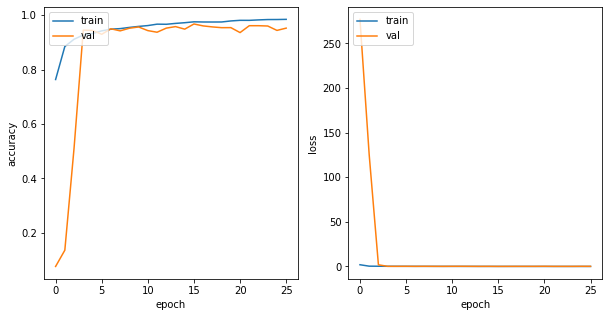

In [ ]:
plot_history(resnet50_history)

In [ ]:
resnet50_model.load_weights('/content/working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = resnet50_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Accuracy: 0.9677777777777777
Global F2 Score: 0.9677777777777777


,Precision,Recall,F-Score,Support
AnnualCrop,0.967521,0.943333,0.955274,600.0
Forest,0.985197,0.998333,0.991722,600.0
HerbaceousVegetation,0.972743,0.951667,0.962089,600.0
Highway,0.959839,0.956000,0.957916,500.0
Industrial,0.989605,0.952000,0.970438,500.0
Pasture,0.958025,0.970000,0.963975,400.0
PermanentCrop,0.919847,0.964000,0.941406,500.0
Residential,0.955272,0.996667,0.975530,600.0
River,0.969758,0.962000,0.965863,500.0
SeaLake,0.994915,0.978333,0.986555,600.0


In [ ]:
# Save the model and the weights
resnet50_model.save('/content/working/ResNet50_eurosat.h5')

4.2 ResNet50V2 Model
---



In [ ]:
resnet50V2_model = compile_model('ResNet50V2', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
resnet50V2_model.summary()


94674944/94668760 [==============================] - 2s 0us/step
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
______________________

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='/content/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)


In [ ]:
# First Pretraining the dense layer
resnet50V2_history = resnet50V2_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)


Epoch 1/50
337/337 [==============================] - ETA: 0s - loss: 1.8956 - categorical_accuracy: 0.6452
Epoch 00001: val_categorical_accuracy improved from -inf to 0.74833, saving model to /content/working/model.weights.best.hdf5
337/337 [==============================] - 53s 157ms/step - loss: 1.8956 - categorical_accuracy: 0.6452 - val_loss: 0.8843 - val_categorical_accuracy: 0.7483
Epoch 2/50
337/337 [==============================] - ETA: 0s - loss: 1.0667 - categorical_accuracy: 0.6965
Epoch 00002: val_categorical_accuracy improved from 0.74833 to 0.76525, saving model to /content/working/model.weights.best.hdf5
337/337 [==============================] - 53s 157ms/step - loss: 1.0667 - categorical_accuracy: 0.6965 - val_loss: 0.8866 - val_categorical_accuracy: 0.7653
Epoch 3/50
337/337 [==============================] - ETA: 0s - loss: 1.0205 - categorical_accuracy: 0.7081
Epoch 00003: val_categorical_accuracy improved from 0.76525 to 0.76786, saving model to /content/working/

In [ ]:
# re-train whole network end2end 
resnet50V2_model = compile_model('ResNet50V2', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

resnet50V2_model.load_weights('/content/working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

resnet50V2_history = resnet50V2_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/100
337/337 [==============================] - ETA: 0s - loss: 1.6695 - categorical_accuracy: 0.5843
Epoch 00001: val_categorical_accuracy did not improve from 0.82701
337/337 [==============================] - 66s 196ms/step - loss: 1.6695 - categorical_accuracy: 0.5843 - val_loss: 1.0859 - val_categorical_accuracy: 0.7478
Epoch 2/100
337/337 [==============================] - ETA: 0s - loss: 0.9150 - categorical_accuracy: 0.7333
Epoch 00002: val_categorical_accuracy improved from 0.82701 to 0.83557, saving model to /content/working/model.weights.best.hdf5
337/337 [==============================] - 66s 197ms/step - loss: 0.9150 - categorical_accuracy: 0.7333 - val_loss: 0.6126 - val_categorical_accuracy: 0.8356
Epoch 3/100
337/337 [==============================] - ETA: 0s - loss: 0.6861 - categorical_accuracy: 0.7981
Epoch 00003: val_categorical_accuracy improved from 0.83557 to 0.87909, saving model to /content/working/model.weights.best.hdf5
337/337 [=======================

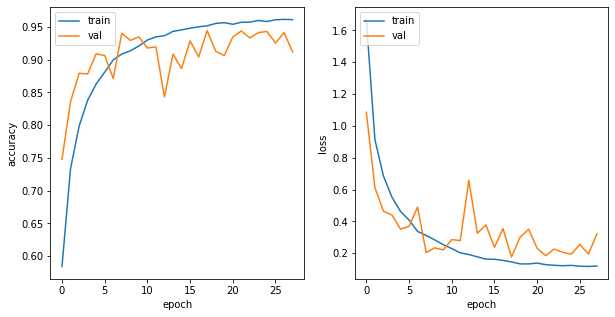

In [ ]:
plot_history(resnet50V2_history)


In [ ]:
resnet50V2_model.load_weights('/content/working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = resnet50V2_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.
Accuracy: 0.9411111111111111
Global F2 Score: 0.9411111111111111


,Precision,Recall,F-Score,Support
AnnualCrop,0.913821,0.936667,0.925103,600.0
Forest,0.920930,0.990000,0.954217,600.0
HerbaceousVegetation,0.973166,0.906667,0.938740,600.0
Highway,0.941667,0.904000,0.922449,500.0
Industrial,0.978723,0.920000,0.948454,500.0
Pasture,0.969309,0.947500,0.958281,400.0
PermanentCrop,0.909639,0.906000,0.907816,500.0
Residential,0.887574,1.000000,0.940439,600.0
River,0.950495,0.960000,0.955224,500.0
SeaLake,0.994652,0.930000,0.961240,600.0


In [ ]:
# Save the model and the weights
resnet50V2_model.save('/content/working/ResNet50V2_eurosat.h5')

4.3 ResNet152V2 Model
---


In [ ]:
resnet152V2_model = compile_model('ResNet152V2', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
resnet152V2_model.summary()


234553344/234545216 [==============================] - 5s 0us/step
Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
____________________

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='/content/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)


In [ ]:
# First Pretraining the dense layer
resnet152V2_history = resnet152V2_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)


Epoch 1/50
337/337 [==============================] - ETA: 0s - loss: 1.7158 - categorical_accuracy: 0.6303
Epoch 00001: val_categorical_accuracy improved from -inf to 0.72656, saving model to /content/working/model.weights.best.hdf5
337/337 [==============================] - 70s 209ms/step - loss: 1.7158 - categorical_accuracy: 0.6303 - val_loss: 1.2129 - val_categorical_accuracy: 0.7266
Epoch 2/50
337/337 [==============================] - ETA: 0s - loss: 1.4166 - categorical_accuracy: 0.6749
Epoch 00002: val_categorical_accuracy improved from 0.72656 to 0.73661, saving model to /content/working/model.weights.best.hdf5
337/337 [==============================] - 68s 201ms/step - loss: 1.4166 - categorical_accuracy: 0.6749 - val_loss: 1.2078 - val_categorical_accuracy: 0.7366
Epoch 3/50
337/337 [==============================] - ETA: 0s - loss: 1.2292 - categorical_accuracy: 0.6923
Epoch 00003: val_categorical_accuracy improved from 0.73661 to 0.76302, saving model to /content/working/

In [ ]:
# re-train whole network end2end 
resnet152V2_model = compile_model('ResNet152V2', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

resnet152V2_model.load_weights('/content/working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

resnet152V2_history = resnet152V2_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/100
337/337 [==============================] - ETA: 0s - loss: 2.2103 - categorical_accuracy: 0.5384
Epoch 00001: val_categorical_accuracy did not improve from 0.81194
337/337 [==============================] - 172s 510ms/step - loss: 2.2103 - categorical_accuracy: 0.5384 - val_loss: 1.6818 - val_categorical_accuracy: 0.6605
Epoch 2/100
337/337 [==============================] - ETA: 0s - loss: 1.0462 - categorical_accuracy: 0.6918
Epoch 00002: val_categorical_accuracy did not improve from 0.81194
337/337 [==============================] - 169s 503ms/step - loss: 1.0462 - categorical_accuracy: 0.6918 - val_loss: 1.5720 - val_categorical_accuracy: 0.6884
Epoch 3/100
337/337 [==============================] - ETA: 0s - loss: 0.7774 - categorical_accuracy: 0.7760
Epoch 00003: val_categorical_accuracy improved from 0.81194 to 0.84580, saving model to /content/working/model.weights.best.hdf5
337/337 [==============================] - 174s 517ms/step - loss: 0.7774 - categorical_accu

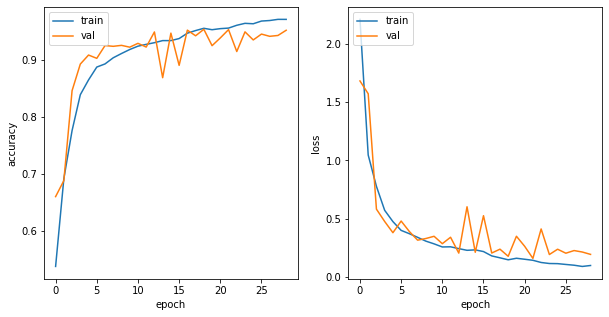

In [ ]:
plot_history(resnet152V2_history)


In [ ]:
resnet152V2_model.load_weights('/content/working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = resnet152V2_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.
Accuracy: 0.9505555555555556
Global F2 Score: 0.9505555555555556


,Precision,Recall,F-Score,Support
AnnualCrop,0.893417,0.950000,0.920840,600.0
Forest,0.972222,0.991667,0.981848,600.0
HerbaceousVegetation,0.975045,0.911667,0.942291,600.0
Highway,0.943158,0.896000,0.918974,500.0
Industrial,0.976842,0.928000,0.951795,500.0
Pasture,0.972081,0.957500,0.964736,400.0
PermanentCrop,0.922000,0.922000,0.922000,500.0
Residential,0.907716,1.000000,0.951626,600.0
River,0.965587,0.954000,0.959759,500.0
SeaLake,0.996610,0.980000,0.988235,600.0


In [ ]:
# Save the model and the weights
resnet152V2_model.save('/content/working/ResNet152V2_eurosat.h5')

4.4 VGG16 Model

In [ ]:
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
vgg16_model.summary()


58892288/58889256 [==============================] - 1s 0us/step
Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________________________________

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='/content/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
vgg16_history = vgg16_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)


Epoch 1/50
337/337 [==============================] - ETA: 0s - loss: 2.0187 - categorical_accuracy: 0.5392
Epoch 00001: val_categorical_accuracy improved from -inf to 0.70275, saving model to /content/working/model.weights.best.hdf5
337/337 [==============================] - 50s 149ms/step - loss: 2.0187 - categorical_accuracy: 0.5392 - val_loss: 0.8995 - val_categorical_accuracy: 0.7028
Epoch 2/50
337/337 [==============================] - ETA: 0s - loss: 1.0800 - categorical_accuracy: 0.6306
Epoch 00002: val_categorical_accuracy did not improve from 0.70275
337/337 [==============================] - 51s 150ms/step - loss: 1.0800 - categorical_accuracy: 0.6306 - val_loss: 0.8700 - val_categorical_accuracy: 0.6812
Epoch 3/50
337/337 [==============================] - ETA: 0s - loss: 1.0866 - categorical_accuracy: 0.6341
Epoch 00003: val_categorical_accuracy did not improve from 0.70275
337/337 [==============================] - 51s 150ms/step - loss: 1.0866 - categorical_accuracy: 0.6

In [ ]:
# re-train whole network end2end 
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

vgg16_model.load_weights('/content/working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

vgg16_history = vgg16_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)


Epoch 1/100
337/337 [==============================] - ETA: 0s - loss: 1.4350 - categorical_accuracy: 0.4960
Epoch 00001: val_categorical_accuracy did not improve from 0.80060
337/337 [==============================] - 63s 187ms/step - loss: 1.4350 - categorical_accuracy: 0.4960 - val_loss: 0.7331 - val_categorical_accuracy: 0.7593
Epoch 2/100
337/337 [==============================] - ETA: 0s - loss: 0.7623 - categorical_accuracy: 0.7455
Epoch 00002: val_categorical_accuracy did not improve from 0.80060
337/337 [==============================] - 62s 184ms/step - loss: 0.7623 - categorical_accuracy: 0.7455 - val_loss: 0.6570 - val_categorical_accuracy: 0.7891
Epoch 3/100
337/337 [==============================] - ETA: 0s - loss: 0.5623 - categorical_accuracy: 0.8277
Epoch 00003: val_categorical_accuracy improved from 0.80060 to 0.87742, saving model to /content/working/model.weights.best.hdf5
337/337 [==============================] - 63s 187ms/step - loss: 0.5623 - categorical_accurac

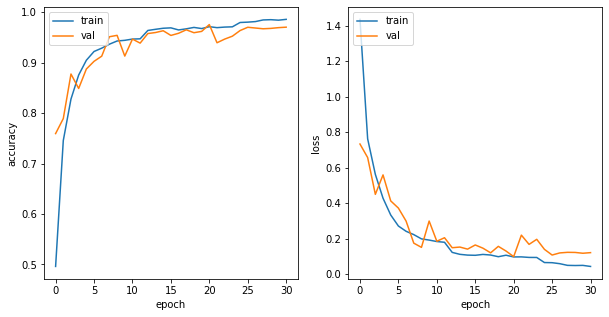

In [ ]:
plot_history(vgg16_history)

In [ ]:
vgg16_model.load_weights('/content/working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg16_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.
Accuracy: 0.9748148148148148
Global F2 Score: 0.9748148148148149


,Precision,Recall,F-Score,Support
AnnualCrop,0.961921,0.968333,0.965116,600.0
Forest,0.970684,0.993333,0.981878,600.0
HerbaceousVegetation,0.961730,0.963333,0.962531,600.0
Highway,0.973843,0.968000,0.970913,500.0
Industrial,0.987928,0.982000,0.984955,500.0
Pasture,0.979381,0.950000,0.964467,400.0
PermanentCrop,0.957055,0.936000,0.946411,500.0
Residential,0.985197,0.998333,0.991722,600.0
River,0.974308,0.986000,0.980119,500.0
SeaLake,0.996644,0.990000,0.993311,600.0


In [ ]:
# Save the model and the weights
vgg16_model.save('/content/working/vgg16_eurosat.h5')

## 4.5 VGG19 Model

In [ ]:
vgg19_model = compile_model('VGG19', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
vgg19_model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_______________________________________________________

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='/content/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
vgg19_history = vgg19_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
337/337 [==============================] - ETA: 0s - loss: 2.3555 - categorical_accuracy: 0.4911
Epoch 00001: val_categorical_accuracy improved from -inf to 0.60919, saving model to /content/working/model.weights.best.hdf5
337/337 [==============================] - 37s 108ms/step - loss: 2.3555 - categorical_accuracy: 0.4911 - val_loss: 1.1004 - val_categorical_accuracy: 0.6092
Epoch 2/50
337/337 [==============================] - ETA: 0s - loss: 1.2179 - categorical_accuracy: 0.5665
Epoch 00002: val_categorical_accuracy improved from 0.60919 to 0.69178, saving model to /content/working/model.weights.best.hdf5
337/337 [==============================] - 36s 107ms/step - loss: 1.2179 - categorical_accuracy: 0.5665 - val_loss: 0.9377 - val_categorical_accuracy: 0.6918
Epoch 3/50
337/337 [==============================] - ETA: 0s - loss: 1.1531 - categorical_accuracy: 0.5926
Epoch 00003: val_categorical_

In [ ]:
# re-train whole network end2end 
vgg19_model = compile_model('VGG19', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

vgg19_model.load_weights('/content/working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

vgg19_history = vgg19_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/100
337/337 [==============================] - ETA: 0s - loss: 1.8236 - categorical_accuracy: 0.3887
Epoch 00001: val_categorical_accuracy did not improve from 0.72693
337/337 [==============================] - 45s 132ms/step - loss: 1.8236 - categorical_accuracy: 0.3887 - val_loss: 1.0288 - val_categorical_accuracy: 0.6068
Epoch 2/100
337/337 [==============================] - ETA: 0s - loss: 0.9743 - categorical_accuracy: 0.6556
Epoch 00002: val_categorical_accuracy did not improve from 0.72693
337/337 [==============================] - 43s 129ms/step - loss: 0.9743 - categorical_accuracy: 0.6556 - val_loss: 0.7996 - val_categorical_accuracy: 0.7234
Epoch 3/100
337/337 [==============================] - ETA: 0s - loss: 0.8113 - categorical_accuracy: 0.7222
Epoch 00003: val_categorical_accuracy improved from 0.72693 to 0.81455, saving model to /content/working/model.weights.best.hdf5
337/337 [==============================] - 44s 132ms/step - loss: 0.8113 - categorical_accurac

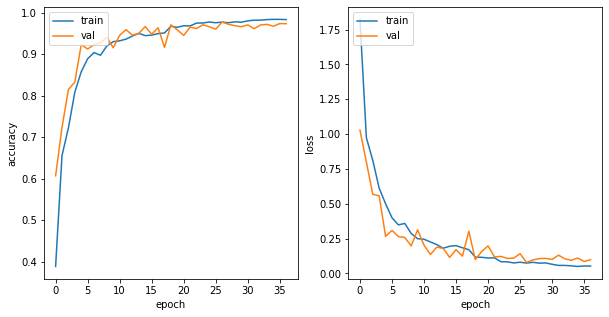

In [ ]:
plot_history(vgg19_history)

In [ ]:
vgg19_model.load_weights('/content/working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg19_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.
Instructions for updating:
Please use Model.predict, which supports generators.
Accuracy: 0.9764814814814815
Global F2 Score: 0.9764814814814816


,Precision,Recall,F-Score,Support
AnnualCrop,0.966957,0.926667,0.946383,600.0
Forest,0.988449,0.998333,0.993367,600.0
HerbaceousVegetation,0.979899,0.975000,0.977444,600.0
Highway,0.976096,0.980000,0.978044,500.0
Industrial,0.970760,0.996000,0.983218,500.0
Pasture,0.984733,0.967500,0.976040,400.0
PermanentCrop,0.914449,0.962000,0.937622,500.0
Residential,0.998328,0.995000,0.996661,600.0
River,0.983871,0.976000,0.979920,500.0
SeaLake,0.996633,0.986667,0.991625,600.0


In [ ]:
# Save the model and the weights
vgg19_model.save('/content/working/vgg19_eurosat.h5')